# Qdrant 101

![qdrant](https://qdrant.tech/images/logo_with_text.png)

Vector databases are a "relatively" new way for interacting with abstract data representations derived from opaque machine learning models -- deep learning architectures being the most common ones. These representations are often called vectors or embeddings and they are a compressed version of the data used to train a machine learning model to accomplish a task (e.g., sentiment analysis, speech recognition, object detection, and many more).

## Table of Contents

1. Learning Outcomes
2. What is Qdrant?
    - What are Vector Databases?
    - Why do We Need Vector Databases??
    - Overview of Qdrant's Architecture    
    - How do We Get Started?
3. Getting Started
    - Adding Points
    - Payload
    - Search
4. Use Cases
    - Natural Language Processing
    - Computer Vision
    - Audio
    - Tabular
7. Conclusion

## 1. Learning Outcomes

## 2. What is Qdrant?

Qdrant "is a vector similarity search engine that provides a production-ready service with a convenient API to store, search, and manage points (i.e. vectors) with an additional payload." You can get started with plain python using the `qdrant-client`, pull the latest docker image of `qdrant` and connect to it locally, or try out Qdrant's Cloud free tier option until you are ready to make the full switch.

### 2.1 What Are Vector Databases?

A vector database is a type of database designed to store and query high-dimensional vectors efficiently. In traditional [OLTP](https://www.ibm.com/topics/oltp) and [OLAP](https://www.ibm.com/topics/olap) databases, data is organized in rows and columns, and queries are performed based on the values in those columns. However, in certain applications, such as machine learning, image recognition, natural language processing, and recommendation systems, data is often represented as vectors in a high-dimensional space.

A vector in this context is a mathematical representation of an object or data point, where each element of the vector corresponds to a specific feature or attribute of the object. For example, in an image recognition system, a vector could represent an image, with each element of the vector representing a pixel value or a descriptor of that pixel.

Vector databases are optimized for storing and querying these high-dimensional vectors efficiently, often using specialized data structures and indexing techniques. They enable fast similarity searches, allowing users to find vectors that are similar to a given query vector based on some distance metric, such as Euclidean distance or cosine similarity.

### 2.2 Why do we need Vector Databases?

Vector databases play a crucial role in various applications that require similarity search, such as recommendation systems, content-based image retrieval, and personalized search. By leveraging efficient indexing and search techniques, vector databases enable faster and more accurate retrieval of similar vectors, enabling advanced data analysis and decision-making.

In addition, other benefits of using vector databases include:
1. Efficient storage and indexing of high-dimensional data.
3. Ability to handle large-scale datasets with billions or trillions of data points.
4. Support for real-time analytics and queries.
5. Ability to handle complex data types, such as images, videos, and natural language text.
6. Improved performance and reduced latency in machine learning and AI applications.
7. Reduced development and deployment time and cost compared to building a custom solution.

Keep in mind that the specific benefits of using a vector database may vary depending on the use case of your organization and the features of the database.

### 2.3 Overview of Qdrant's Architecture (High-Level)

![qdrant](../images/qdrant_archi.png)

TODO: Add storage and third-party integrations to the image above

- Collections
- Distance Metrics
- Points
    - id
    - Vector
    - Payload
- Storage
- Clients

### 2.4 How do we get started?

The open source version of Qdrant is available as a docker image and it can be pulled and run from any machine running docker. If you don't have Docker installed in your PC you can follow the instructions in the official documentation [here](https://docs.docker.com/get-docker/). After that, open your terminal start by downloading the image with the following command.

```sh
docker pull qdrant/qdrant
```

Next, initialize Qdrant with the following command, and you should be good to go.

```sh
docker run -p 6333:6333 \
    -v $(pwd)/qdrant_storage:/qdrant/storage \
    qdrant/qdrant
```

If you experience any issues during the start process, please let us know in our [discord channel here](https://qdrant.to/discord). We are always available to help.

Now that you have Qdrant up and running, your next step is to pick a client to connect to it. We'll be using Python as it has the most mature data tools ecosystem out there. Therefore, let's start setting up our dev environment with the tools we'll be using.

```sh
# with mamba or conda
mamba env create -n my_env python=3.10
mamba activate my_env

# or with virtualenv
python -m venv venv
source venv/bin/activate

# install packages
pip install qdrant-client transformers datasets pandas numpy torch
```

After your have your environment ready, let's get started with Qdrant.

**Note:** At the time of writing, Qdrant supports Rust, GO, Python and TypeScript. We might see other programming languages getting added in the future.

## 3. Getting Started

The two modules we'll use the most are the `QdrantClient` and the `models` one. The former allows to connect to Qdrant or it allows us to run an in-memory database with the parameter `host=` switched to `":memory:"` (this is a great feature for testing in a CI/CD pipeline). We'll start by instantiating our client using `host="localhost"` and `port=6333` and we'll check the status of it with .

In [2]:
from qdrant_client import QdrantClient
from qdrant_client.http import models
from qdrant_client.http.models import CollectionStatus

In [3]:
client = QdrantClient(host="localhost", port=6333)
client

In OLTP and OLAP databases we call specific bundles of data, **Tables**, but in vector databases, we refer to these bundles of vectors as **collections**. In the same way in which we can create many tables in a database, we can create many collections in a vector-based db using a client. The key difference to note is that when we create a collection, we need to specify the width of the collection beforehand with the parameter `size=...`, as well as the similarity metric with the parameter `distance=...` (which can be changed later on).

The distances currently supported by Qdrant are:
- Cosine Similarity
- Dot Product
- Euclidean Distance

Let's create our first collection and have the vectors be of with 100 and the distance set to [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity). Please note that, at the time of writing, Qdrant supports cosine similarity, dot product and 

In [ ]:
first_collection = client.recreate_collection(
    collection_name="first_collection",
    vectors_config=models.VectorParams(size=100, distance=models.Distance.COSINE)
)
print(first_collection)

In [ ]:
collection_info = client.get_collection(collection_name="first_collection")
collection_info

Note the information available 

In [ ]:
assert collection_info.status == CollectionStatus.GREEN
assert collection_info.vectors_count == 0

In [ ]:
# we can check that our collection was indeed created with
client.get_collections()

There's a couple of things to notice from what we have done.
- The first is that when we initiated our docker image, we created a local directory, `qdrant_storage`, where all of our collections, plus their metadata, will be saved at. You can have a look at that directory in a *nix system with `tree qdrant_storage -L 2`. You should see the following.
    ```bash
    qdrant_storage
    ├── aliases
    │   └── data.json
    ├── collections
    │   └── my_first_collection
    └── raft_state
    ```
- The second is that we used `client.create_collection` and this command can only be used once per collection. To recreate the collection with new parameters and the like, we would use `client.recreate_collection` instead.

Now that we know how to create collections, let's create a bit of fake data and add some vectors to our collection.

#### 4.3.2 Adding Points

The points are the central entity that Qdrant operates with, and these points contain records consisting of a vector, an optional id and an optional payload (which we'll talk more about in the next section).

The optional id can be represented by unassigned integers or UUIDs. We are going a range of numbers for this.

In [ ]:
data = np.random.uniform(low=-1.0, high=1.0, size=(1_000, 100))
data

In [ ]:
index = list(range(len(data)))
index[-10:]

In [ ]:
client.upsert(
    collection_name="my_first_collection",
    points=models.Batch(
        ids=index,
        vectors=data.tolist()
    )
)

We can retrieve specific points based on their ID (for example, artist X with ID 1000) and get some additional information from that result.

In [ ]:
client.retrieve(
    collection_name="my_first_collection",
    ids=[100],
    with_vectors=True # we can turn this on and off depending on our needs
)

We can also update our collection one point at a time, for example, as new data comes in.

In [ ]:
def create_song():
    return np.random.uniform(low=-1.0, high=1.0, size=100).tolist()

In [ ]:
client.upsert(
    collection_name="my_first_collection",
    points=[
        models.PointStruct(
            id=1000,
            vector=create_song(),
        )
    ]
)

We can also delete it in a straightforward fashion.

In [ ]:
client.count(
    collection_name="my_first_collection", 
    exact=True,
)

In [ ]:
client.delete(
    collection_name="my_first_collection",
    points_selector=models.PointIdsList(
        points=[1000],
    ),
)

In [ ]:
client.count(
    collection_name="my_first_collection", 
    exact=True,
)

#### 4.3.3 Payloads

Qdrant has incredible features on top of speed and reliability, and one of its most useful ones is without a doubt the ability to store additional information along with vectors. In Qdrant terminology, this information is considered a payload and it is represented as a JSON file. In addition, not only can you get this information back when you search in the database, but you can also filter your search by the parameters in the payload, and we'll see how in a second.

Imagine the fake vectors we created actually represented a song. If we were building a recommender system for songs then, naturally, the things we would want to get back would be the song itself, the artist, maybe the genre, and so on.

What we'll do here is to take advantage of a Python package call `faker` and create a bit of information to add to our payload.

In [ ]:
from faker import Faker

In [ ]:
fake_something = Faker()
fake_something.name()

In [ ]:
payload = []

for i in range(len(data)):
    payload.append(
        {
            "artist": fake_something.name(),
            "song": " ".join(fake_something.words()),
            "url_song": fake_something.url(),
            "year": fake_something.year(),
            "country": fake_something.country()
        }
    )

payload[:3]

In [ ]:
client.upsert(
    collection_name="my_first_collection",
    points=models.Batch(
        ids=index,
        vectors=data.tolist(),
        payloads=payload
    )
)

In [ ]:
resutls = client.retrieve(
    collection_name="my_first_collection",
    ids=[10, 50, 100, 500],
    with_vectors=False
)
resutls

In [ ]:
resutls[0].payload

In [ ]:
# client.clear_payload(
#     collection_name="my_first_collection",
#     points_selector=models.PointIdsList(
#         points=index,
#     )
# )

#### 4.3.4 Search

Now that we have our vectors with an ID and a payload, we can explore a few of ways in which we can search for content when, in our use case, new music gets selected. Let's check it out.

Say, for example, that a new song comes in and our model immediately transforms it into a vector.

In [ ]:
living_la_vida_loca = create_song()

In [ ]:
client.search(
    collection_name="my_first_collection",
    query_vector=living_la_vida_loca,
    limit=10
)

Now imagine that we only want Australian songs recommended to us.

In [ ]:
aussie_songs = models.Filter(
    must=[models.FieldCondition(key="country", match=models.MatchValue(value="Australia"))]
)

In [ ]:
client.search(
    collection_name="my_first_collection",
    query_vector=living_la_vida_loca,
    query_filter=aussie_songs,
    limit=5
)

Lastly, say we want aussie songs but we don't care how new or old these songs are.

In [ ]:
client.search(
    collection_name="my_first_collection",
    query_vector=living_la_vida_loca,
    query_filter=aussie_songs,
    with_payload=models.PayloadSelectorExclude(exclude=["year"]),
    limit=5
)

As you can see, the possibilities are endless.

## 4. Use Cases

The most common use case you will find as of today will most-likely involve language-based Generative AI models, and understandably so. Models like GPT-3, Codex, 

### 4.1 Natural Language Processing

In NLP, vector databases are used to store word embeddings. Word embeddings are vector representations of words that capture their semantic meaning. They are used to improve the performance of NLP tasks such as text classification, machine translation, and question answering.



In [12]:
from transformers import GPT2Tokenizer, GPT2Model
from datasets import load_dataset
import numpy as np
import torch

In [2]:
dataset = load_dataset("ag_news", split="train")

Found cached dataset ag_news (/home/ramonperez/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)


In [3]:
dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 120000
})

In [31]:
dataset[1000]

{'text': 'European Union Extends Microsoft-Time Warner Review BRUSSELS, Belgium (AP) -- European antitrust regulators said Monday they have extended their review of a deal between Microsoft Corp. (MSFT) and Time Warner Inc...',
 'label': 3}

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2').to(device)

In [17]:
tokenizer.eos_token

'<|endoftext|>'

In [18]:
tokenizer.pad_token = tokenizer.eos_token

In [19]:
text = "That movie was amazing"
em = tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors="pt").to(device)
em

{'input_ids': tensor([[2504, 3807,  373, 4998]]), 'attention_mask': tensor([[1, 1, 1, 1]])}

In [20]:
with torch.no_grad():
    embs = model(**em)
embs

BaseModelOutputWithPastAndCrossAttentions(last_hidden_state=tensor([[[-0.0243,  0.0809, -0.1719,  ..., -0.1495, -0.2119, -0.1561],
         [ 0.2243,  0.4969, -0.6944,  ..., -0.0113,  0.2405, -0.3173],
         [ 0.1514,  0.5465, -0.1781,  ...,  0.1972, -0.0169,  0.0049],
         [ 0.2502, -0.0236, -0.8354,  ...,  0.0674, -0.1227,  0.1893]]]), past_key_values=((tensor([[[[-1.3860,  1.7861,  0.6037,  ..., -1.5021, -0.7941,  1.5095],
          [-2.9234,  3.6486,  1.0172,  ..., -0.7987, -1.5528,  2.0401],
          [-1.8623,  2.1817,  2.0293,  ..., -1.6566, -3.0061,  2.5634],
          [-2.3184,  1.9345,  1.9676,  ..., -1.1781, -2.4896,  1.8555]],

         [[-0.3181,  0.2126, -0.4151,  ..., -0.6093,  2.0578,  0.9138],
          [-0.7923, -1.3635, -0.2944,  ..., -0.3620,  4.1229,  0.7981],
          [ 0.8762, -0.5365, -0.0074,  ..., -2.2366,  3.8148,  0.5819],
          [ 0.9763, -0.5965, -1.2001,  ..., -1.1998,  4.3242,  2.0797]],

         [[-0.3295,  0.0997,  0.8167,  ..., -1.2354, -1

In [21]:
embs.last_hidden_state.size()

torch.Size([1, 4, 768])

In [42]:
def mean_pooling(model_output, attention_mask):

    token_embeddings = model_output[0]
    input_mask_expanded = (attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float())
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

def embed_text(examples):
    inputs = tokenizer(
        examples["text"], padding=True, truncation=True, return_tensors="pt"
    ).to(device)
    with torch.no_grad():
        model_output = model(**inputs)
    pooled_embeds = mean_pooling(model_output, inputs["attention_mask"])
    return {"embedding": pooled_embeds.cpu().numpy()}

In [45]:
dataset = dataset.shuffle(42).select(range(3000)).map(embed_text, batched=True, batch_size=128)

Loading cached shuffled indices for dataset at /home/ramonperez/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548/cache-dd0ff9596fea92b0.arrow


Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

### 4.2 Computer Vision

In CV, vector databases are used to store image features. Image features are vector representations of images that capture their visual content. They are used to improve the performance of CV tasks such as object detection, image classification, and image retrieval.

In [6]:
from transformers import AutoImageProcessor, ResNetForImageClassification

In [21]:
dataset = load_dataset("marmal88/skin_cancer", split='train')
dataset

Found cached dataset parquet (/home/ramonperez/.cache/huggingface/datasets/marmal88___parquet/marmal88--skin_cancer-4d80d9330324f110/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


Dataset({
    features: ['image', 'image_id', 'lesion_id', 'dx', 'dx_type', 'age', 'sex', 'localization'],
    num_rows: 9577
})

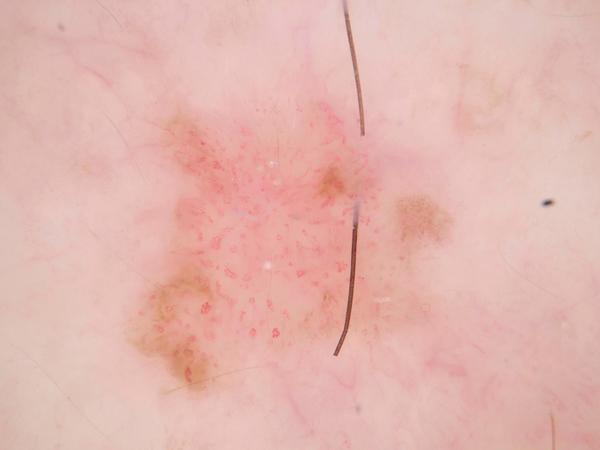

In [26]:
image = dataset[100]["image"]
image

In [10]:
image_processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50", outpu)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [14]:
inputs = image_processor(image, return_tensors="pt")
inputs.keys(), inputs.pixel_values.shape

(dict_keys(['pixel_values']), torch.Size([1, 3, 224, 224]))

In [20]:
ResNetForImageClassification.from_pretrained??

Signature:
ResNetForImageClassification.from_pretrained(
    pretrained_model_name_or_path: Union[str, os.PathLike, NoneType],
    *model_args,
    **kwargs,
)
Source:   
    @classmethod
    def from_pretrained(cls, pretrained_model_name_or_path: Optional[Union[str, os.PathLike]], *model_args, **kwargs):
        r"""
        Instantiate a pretrained pytorch model from a pre-trained model configuration.

        The model is set in evaluation mode by default using `model.eval()` (Dropout modules are deactivated). To train
        the model, you should first set it back in training mode with `model.train()`.

        The warning *Weights from XXX not initialized from pretrained model* means that the weights of XXX do not come
        pretrained with the rest of the model. It is up to you to train those weights with a downstream fine-tuning
        task.

        The warning *Weights from XXX not used in YYY* means that the layer XXX is not used by YYY, therefore those
        weights ar

In [19]:
with torch.no_grad():
    features = model(**inputs)
features

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 with torch.no_grad():                                                                        │
│ ❱ 2 │   features = model.get_output_embeddings(**inputs)                                         │
│   3 features                                                                                     │
│   4                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: PreTrainedModel.get_output_embeddings() got an unexpected keyword argument 'pixel_values'

In [ ]:






# model predicts one of the 1000 ImageNet classes
predicted_label = logits.argmax(-1).item()
print(model.config.id2label[predicted_label])

### 4.3 Audio

### 4.4 Tabular

## 5. Conclusion